***4.1 Softmax Regression***

**4.2 Image Classification Dataset**

In [ ]:
%%capture
!pip install --upgrade d2l==1.0.0a0
%matplotlib inline
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [ ]:
class FashionMNIST(d2l.DataModule):
  def __init__(self, batch_size = 64, resize = (28,28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor()])
    self.train = torchvision.datasets.FashionMNIST(
        root = self.root, train = True, transform = trans, download = True)
    self.val = torchvision.datasets.FashionMNIST(
        root = self.root, train = False, transform = trans, download = True)


In [ ]:
t = time.time()
data = FashionMNIST(batch_size = 1, resize = (32,32))
print(f"Total elapsed = {time.time() - t:.2f} sec")

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.87MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 130kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.46MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]

Total elapsed = 10.01 sec


In [ ]:
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
  labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [labels[int(i)] for i in indices]


In [ ]:
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data, self.batch_size, shuffle = train,
                                     num_workers = self.num_workers)


In [ ]:
X,y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([1, 1, 32, 32]) torch.float32 torch.Size([1]) torch.int64


In [ ]:
t = time.time()
for X,y in data.train_dataloader():
  continue
print(f"Time: {time.time() - t}")

Time: 113.91665029525757


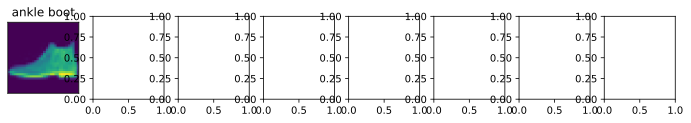

In [ ]:
@d2l.add_to_class(FashionMNIST)
def visualize(self, batch, nrows = 1, ncols = 8, labels = []):
  X, y = batch
  if not labels:
    labels = self.text_labels(y)
  d2l.show_images(X.squeeze(1), nrows, ncols, titles = labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [ ]:
class Classifier(d2l.Module):
  def validation_step(self, batch):
    Y_hat = self()
    self.plot('loss', self.loss(Y_hat, batch[-1]), train = False)
    self.plot('acc', self.accuracy(Y_hat, batch[-1]), train = False)


In [ ]:
@d2l.add_to_class(d2l.Module)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

In [ ]:
@d2l.add_to_class(Classifier)
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

In [ ]:
#flag for review
@d2l.add_to_class(Classifier)
def accuracy(self, Y_hat, Y, averaged = True):
  #we assume that the last dimension stores the prediction, everything else is prediction data?
  #Y_hat.shape[-1] is the last dimension, reshape it to whatever that dimension is with the other -1
  Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))

  preds = Y_hat.argmax(axis = 1).type(Y.dtype)
  compare = (preds == Y.reshape(-1)).type(torch.float32)
  return compare.mean() if averaged else compare

In [ ]:
arr = torch.arange(12).reshape(3,4)
print(arr)
# arr.argmax(axis = 1).type(arr.dtype)
arr.argmax(axis = 1).type(arr.dtype)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


tensor([3, 3, 3])

**4.4 SoftMax**

In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [ ]:
def softmax(X):
  X_exp = torch.exp(X)
  denom = X_exp.sum(axis = 1, keepdim=True)
  return X_exp / denom

In [ ]:
X = torch.rand((2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis = 1)

(tensor([[0.2207, 0.1975, 0.1764, 0.2537, 0.1516],
         [0.1692, 0.2419, 0.2173, 0.1322, 0.2394]]),
 tensor([1.0000, 1.0000]))

In [ ]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [ ]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self,X):
  X = X.reshape((-1, self.W.shape[0]))
  return softmax(torch.matmul(X, self.W) + self.b)

In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [ ]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

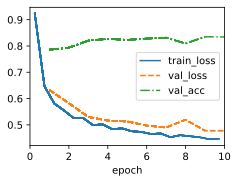

In [ ]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [ ]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

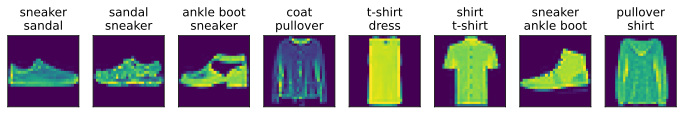

In [ ]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
class SoftmaxRegression(d2l.Classifier):
  def __init__(self,num_outputs, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(nn.Flatten(),
                             nn.LazyLinear(num_outputs))
  def forward(self, X):
    return self.net(X)

In [ ]:
@d2l.add_to_class(d2l.Classifier)
def loss(self, Y_hat, Y, averaged = True):
  Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
  Y = Y.reshape((-1,))
  return F.cross_entropy(
      Y_hat, Y, reduction = 'mean' if averaged else 'non'
  )

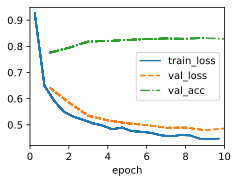

In [ ]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)